In [1]:
# Install OpenCV with SIFT support (Just once)
!pip install --quiet opencv-contrib-python

In [2]:
!git clone https://github.com/Amino21786/LMSMedicalSummerSchoolandConference.git

Cloning into 'LMSMedicalSummerSchoolandConference'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 89 (delta 24), reused 49 (delta 15), pack-reused 26 (from 1)
Receiving objects: 100% (89/89), 152.34 MiB | 39.36 MiB/s, done.
Resolving deltas: 100% (24/24), done.


PDF Images Found:
[0] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagespdf/pdf1_img1.jpg
[1] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagespdf/pdf1_img2.jpg
[2] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagespdf/pdf2_img1.jpg
[3] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagespdf/pdf2_img2.jpg

 DICOM Images Found:
[0] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagesdicom/pydicom1_img1.jpg
[1] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagesdicom/pydicom1_img2.jpg
[2] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagesdicom/pydicom1_img3.jpg
[3] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagesdicom/pydicom1_img4.jpg
[4] /content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagesdicom/pydicom1_img5.jpg
[5] /content/LMSMedic

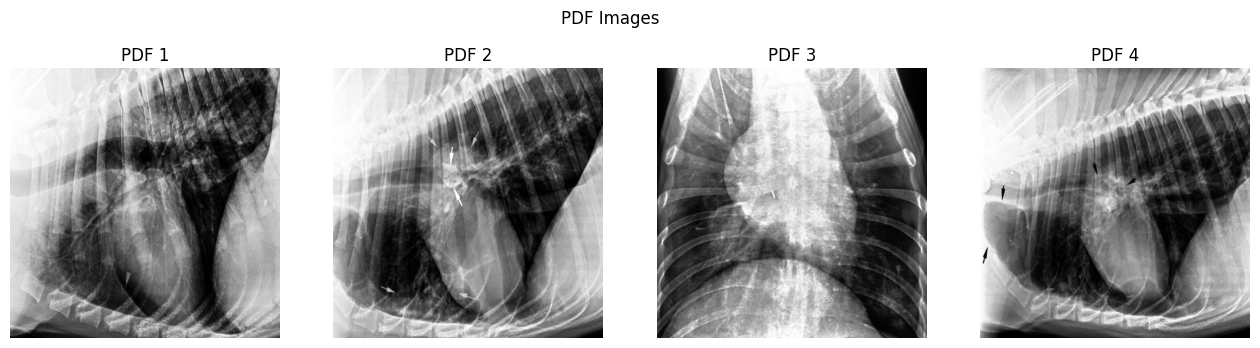

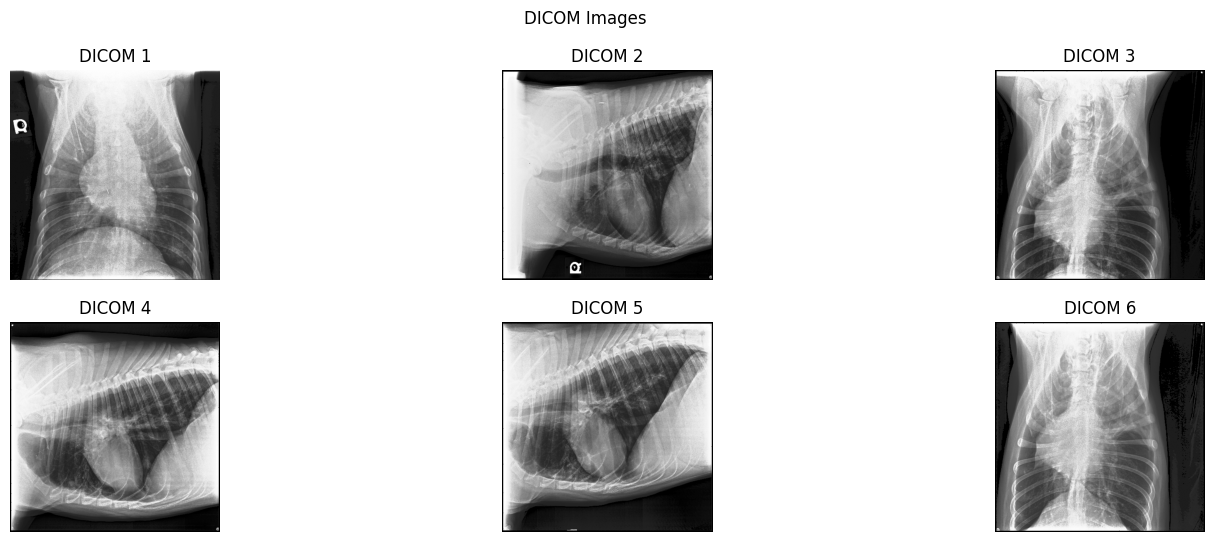

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob

# Set directories
pdf_dir = '/content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagespdf'
dicom_dir = '/content/LMSMedicalSummerSchoolandConference/Summer School/CXRSChallenge/imagesdicom'

# Load all image types from PDF folder (from glob)
pdf_paths = sorted(
    glob(os.path.join(pdf_dir, '*.jpg')) +
    glob(os.path.join(pdf_dir, '*.jpeg')) +
    glob(os.path.join(pdf_dir, '*.png'))
)

# Load all .jpg files from DICOM folder (I want to check!)
dicom_paths = sorted(glob(os.path.join(dicom_dir, '*.jpg')))

print("PDF Images Found:")
for i, path in enumerate(pdf_paths):
    print(f"[{i}] {path}")

print("\n DICOM Images Found:")
for i, path in enumerate(dicom_paths):
    print(f"[{i}] {path}")

# Preprocessing function
# 512 is standard
def load_image(path, size=(512, 512)):
  #  Load the image in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  # check that's loaded (trust issues :))
    if img is None:
        print(f"Could not load: {path}")
        return None
    # Resize the image
    img = cv2.resize(img, size)
    # It spreads out the pixel brightness values (equalizing the histogram)
    img = cv2.equalizeHist(img)
    return img # Return the processed image

# Load images
pdf_images = [load_image(p) for p in pdf_paths if load_image(p) is not None]
dicom_images = [load_image(p) for p in dicom_paths if load_image(p) is not None]

print(f"\n Loaded {len(pdf_images)} PDF images and {len(dicom_images)} DICOM images.")

# Visual check for both
plt.figure(figsize=(16, 4))
for i, img in enumerate(pdf_images):
    plt.subplot(1, len(pdf_images), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"PDF {i+1}")
    plt.axis('off')
plt.suptitle("PDF Images")
plt.show()

plt.figure(figsize=(18, 6))
for i, img in enumerate(dicom_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"DICOM {i+1}")
    plt.axis('off')
plt.suptitle("DICOM Images")
plt.show()



 Matching PDF 1...
 PDF 1 → Best match: DICOM 2 | Scale: 1.20 | Match score: 0.1801

 Matching PDF 2...
 PDF 2 → Best match: DICOM 5 | Scale: 1.20 | Match score: 0.1698

 Matching PDF 3...
 PDF 3 → Best match: DICOM 1 | Scale: 1.20 | Match score: 0.1086

 Matching PDF 4...
 PDF 4 → Best match: DICOM 4 | Scale: 1.20 | Match score: 0.0709


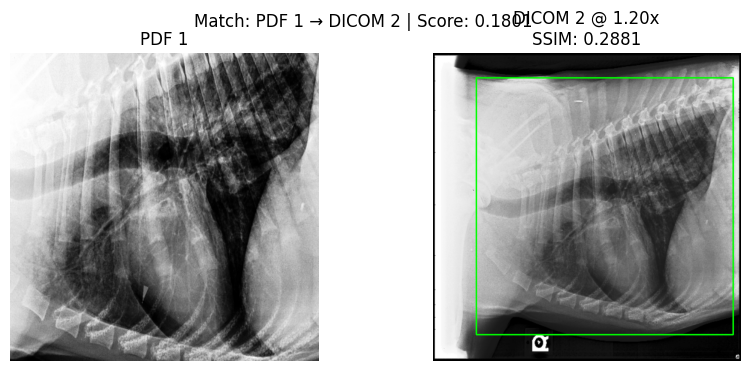

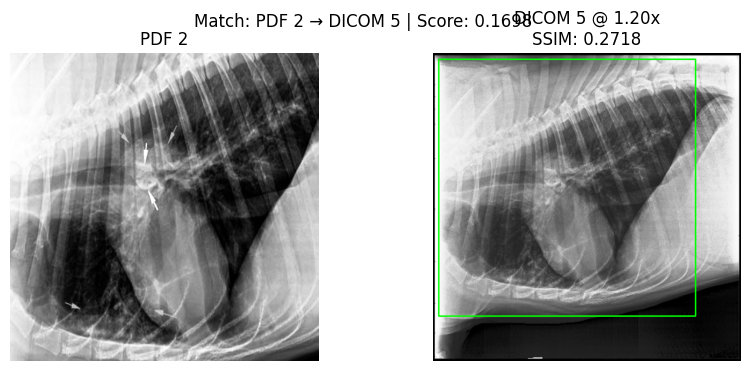

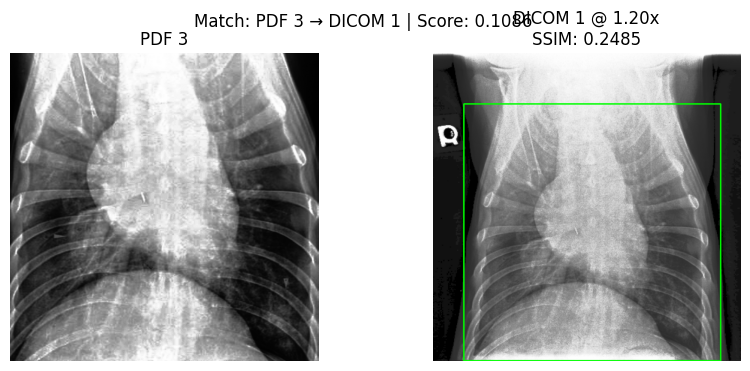

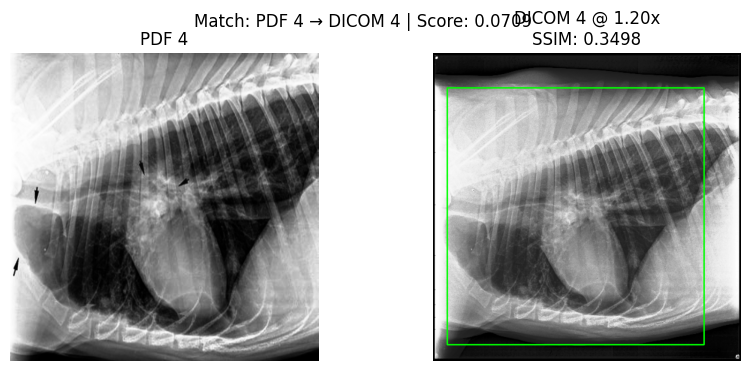

In [4]:
# Notes:
# Resize all to 512×512 during loading
# Resize DICOM again at different scales during matching
# Matching score the lower the better :)
# < 0.1 excellent, within 0.2 and 0.2 acceptable
# The higher SSIM the better :)
# SSIM > 0.30 very good perceptual alignment
# < 0.25 could be affected by arrow overlays

# compare two images and give a similarity score from 0 to 1, 1 means the same
from skimage.metrics import structural_similarity as ssim
import imutils

# Function: Perform multi-scale template matching
# Takes two grayscale images: one from a PDF, one from a DICOM
# Tries to match them at different sizes (scales) because they might not be the same size
# Uses template matching it's a method that slides the PDF image over the DICOM and checks where it fits best
def multiscale_match(pdf_img, dicom_img, scales=np.linspace(0.8, 1.2, 9), method=cv2.TM_SQDIFF_NORMED):
    h, w = pdf_img.shape
    # dictionary to keep track of the best match we find.
    best = {'score': float('inf'), 'scale': None, 'loc': None, 'dicom_resized': None}

    for scale in scales:
        # Resize DICOM image from 0.8x to 1.2x
        resized = imutils.resize(dicom_img, width=int(dicom_img.shape[1] * scale))
        # Resize the DICOM image to different sizes and try to fit the PDF image in it
        # Skip this size if it's too small to fit the PDF image
        if resized.shape[0] < h or resized.shape[1] < w:
            continue

        # Template match
        # Match them using OpenCV's matchTemplate
        result = cv2.matchTemplate(resized, pdf_img, method)
        # Compares the PDF image to every possible location in the resized DICOM image
        min_val, _, min_loc, _ = cv2.minMaxLoc(result)
        # Finds the location with the lowest score, meaning the best match for this scale
        # If this match is better than previous ones, save it as the best so far.
        if min_val < best['score']:
            best.update({
                'score': min_val,
                'scale': scale,
                'loc': min_loc,
                'dicom_resized': resized
            })

    return best

# Part 3: Match all PDF images to DICOM images
results = []
for i, pdf_img in enumerate(pdf_images):
    print(f"\n Matching PDF {i+1}...")
    best_match = {'score': float('inf')}

    # Loop through each PDF image.
    # For each PDF, compare it to every DICOM image.
    for j, dicom_img in enumerate(dicom_images):
       # Keep the best match among all DICOMs.
        match = multiscale_match(pdf_img, dicom_img)
        if match['score'] < best_match.get('score', float('inf')):
            best_match.update(match)
            best_match['pdf_index'] = i
            best_match['dicom_index'] = j

    # Save the best result for this PDF image.
    results.append(best_match)
    print(f" PDF {i+1} → Best match: DICOM {best_match['dicom_index']+1} | "
          f"Scale: {best_match['scale']:.2f} | Match score: {best_match['score']:.4f}")

# Part 4: Visualise matches + compute SSIM
for result in results:
    i = result['pdf_index']
    j = result['dicom_index']
    scale = result['scale']
    top_left = result['loc']
    resized_dicom = result['dicom_resized']
    h, w = pdf_images[i].shape
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Extract patch and calculate SSIM
    patch = resized_dicom[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    if patch.shape != pdf_images[i].shape:
        patch = cv2.resize(patch, (w, h))
    ssim_score = ssim(pdf_images[i], patch)

    # Visualisation
    vis = cv2.cvtColor(resized_dicom, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(vis, top_left, bottom_right, (0, 255, 0), 2)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pdf_images[i], cmap='gray')
    plt.title(f"PDF {i+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(vis)
    plt.title(f"DICOM {j+1} @ {scale:.2f}x\nSSIM: {ssim_score:.4f}")
    plt.axis('off')

    plt.suptitle(f"Match: PDF {i+1} → DICOM {j+1} | Score: {result['score']:.4f}")
    plt.show()


In [6]:
# Store transformation metadata for later use in Step 3 and 4
match_metadata = {}

for result in results:
    pdf_idx = result['pdf_index']
    dicom_idx = result['dicom_index']
    scale = result['scale']
    top_left = result['loc']

    match_metadata[f"pdf{pdf_idx+1}"] = {
        "matched_dicom_index": dicom_idx,
        "scale": scale,
        "top_left": top_left
    }

# Print the full dictionary nicely
import pprint
pp = pprint.PrettyPrinter(indent=2)
print(" Matching Metadata (for Step 3+4):")
pp.pprint(match_metadata)


 Matching Metadata (for Step 3+4):
{ 'pdf1': { 'matched_dicom_index': 1,
            'scale': np.float64(1.2),
            'top_left': (86, 49)},
  'pdf2': { 'matched_dicom_index': 4,
            'scale': np.float64(1.2),
            'top_left': (11, 12)},
  'pdf3': { 'matched_dicom_index': 0,
            'scale': np.float64(1.2),
            'top_left': (61, 101)},
  'pdf4': { 'matched_dicom_index': 3,
            'scale': np.float64(1.2),
            'top_left': (28, 69)}}


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create SIFT detector
sift = cv2.SIFT_create()

# Store results
sift_results = {}

for pdf_idx, pdf in enumerate(pdf_images):
    best = {'inliers': 0, 'matches': 0, 'dicom_idx': None, 'H': None}
    print(f"\n PDF {pdf_idx+1} matching...")

    for dicom_idx, dicom in enumerate(dicom_images):
        kp1, des1 = sift.detectAndCompute(pdf, None)
        kp2, des2 = sift.detectAndCompute(dicom, None)

        if des1 is None or des2 is None:
            continue

        # Match with ratio test
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)

        good = [m for m, n in matches if m.distance < 0.75 * n.distance]

        if len(good) >= 4:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

            H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            inliers = int(np.sum(mask)) if mask is not None else 0
        else:
            H = None
            inliers = 0

        print(f"  PDF {pdf_idx+1} vs DICOM {dicom_idx+1}: Matches = {len(good)}, Inliers = {inliers}")

        # Keep best
        if inliers > best['inliers']:
            best.update({
                'inliers': inliers,
                'matches': len(good),
                'dicom_idx': dicom_idx,
                'H': H,
                'good_matches': good,
                'kp_pdf': kp1,
                'kp_dicom': kp2
            })

    # Store best match for this PDF
    sift_results[f"pdf{pdf_idx+1}"] = best
    print(f" Best match for PDF {pdf_idx+1}: DICOM {best['dicom_idx']+1} with {best['inliers']} inliers")



 PDF 1 matching...
  PDF 1 vs DICOM 1: Matches = 15, Inliers = 5
  PDF 1 vs DICOM 2: Matches = 211, Inliers = 196
  PDF 1 vs DICOM 3: Matches = 10, Inliers = 5
  PDF 1 vs DICOM 4: Matches = 17, Inliers = 5
  PDF 1 vs DICOM 5: Matches = 14, Inliers = 5
  PDF 1 vs DICOM 6: Matches = 8, Inliers = 4
 Best match for PDF 1: DICOM 2 with 196 inliers

 PDF 2 matching...
  PDF 2 vs DICOM 1: Matches = 16, Inliers = 5
  PDF 2 vs DICOM 2: Matches = 15, Inliers = 5
  PDF 2 vs DICOM 3: Matches = 16, Inliers = 5
  PDF 2 vs DICOM 4: Matches = 29, Inliers = 7
  PDF 2 vs DICOM 5: Matches = 411, Inliers = 386
  PDF 2 vs DICOM 6: Matches = 11, Inliers = 4
 Best match for PDF 2: DICOM 5 with 386 inliers

 PDF 3 matching...
  PDF 3 vs DICOM 1: Matches = 216, Inliers = 200
  PDF 3 vs DICOM 2: Matches = 15, Inliers = 6
  PDF 3 vs DICOM 3: Matches = 18, Inliers = 5
  PDF 3 vs DICOM 4: Matches = 18, Inliers = 5
  PDF 3 vs DICOM 5: Matches = 18, Inliers = 5
  PDF 3 vs DICOM 6: Matches = 17, Inliers = 5
 Best ma

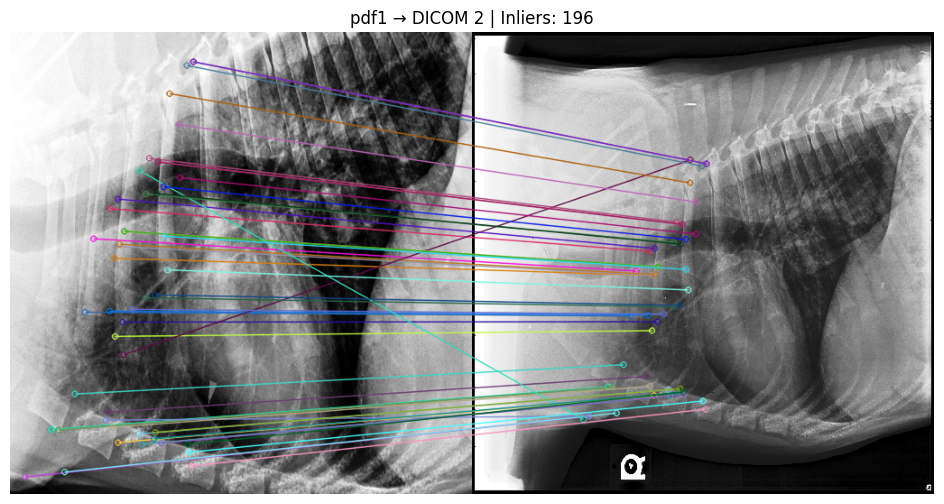

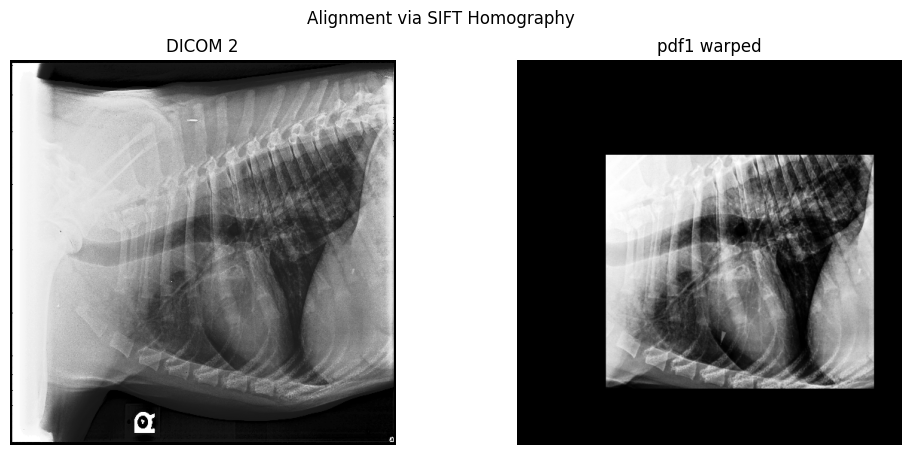

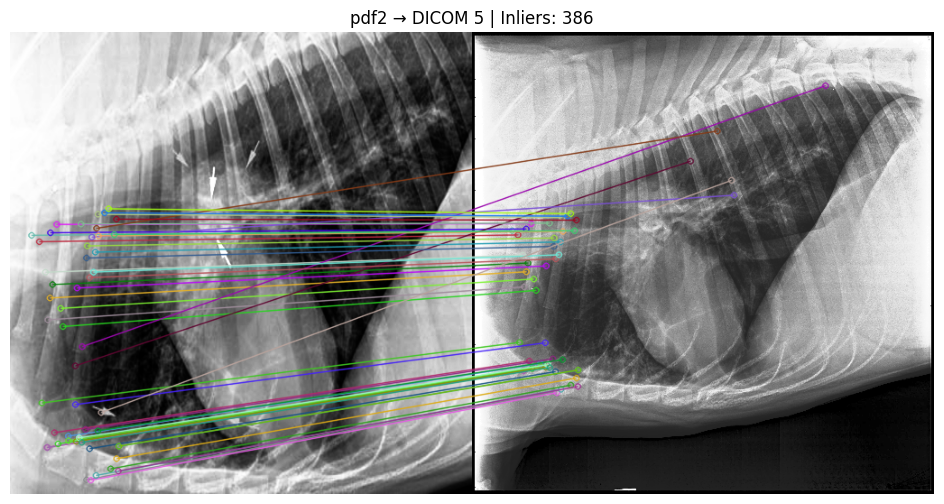

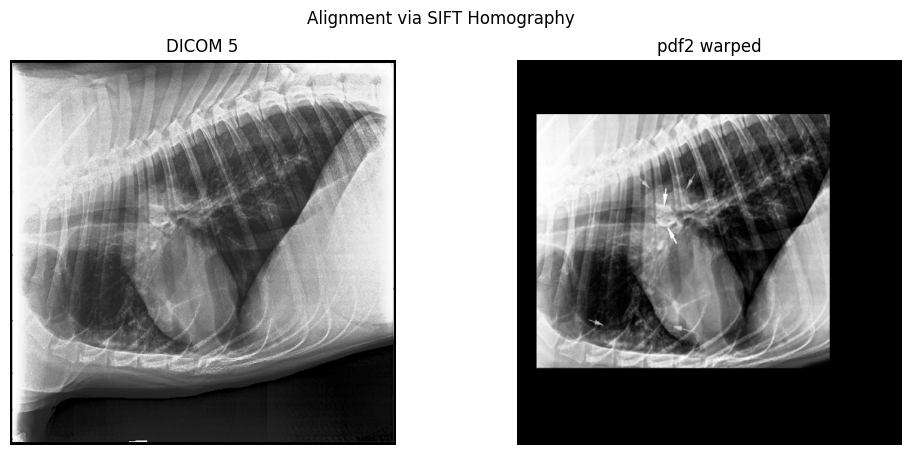

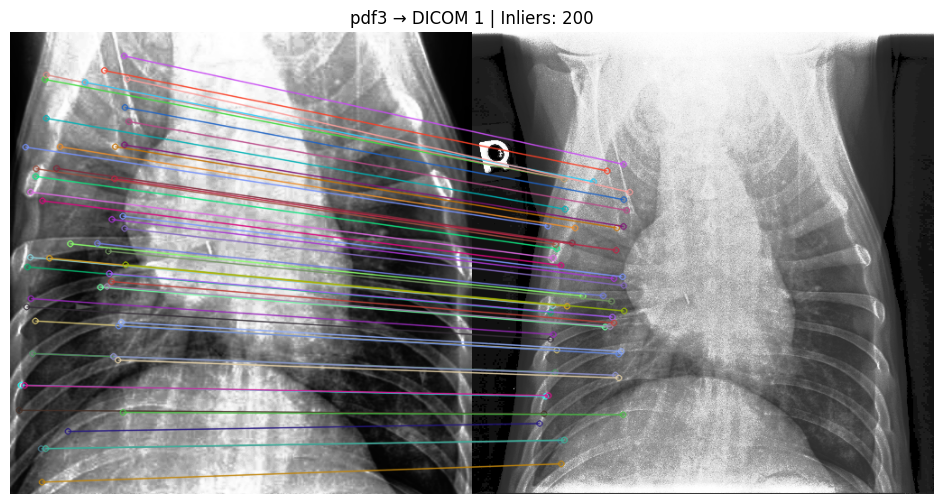

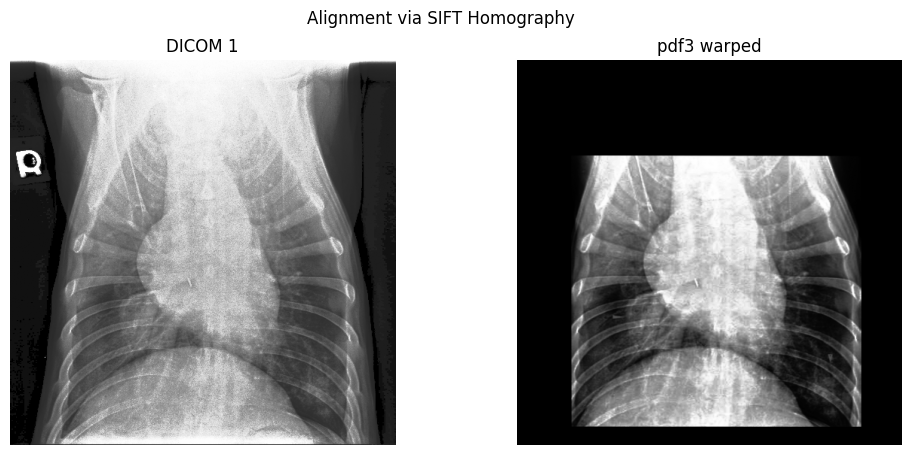

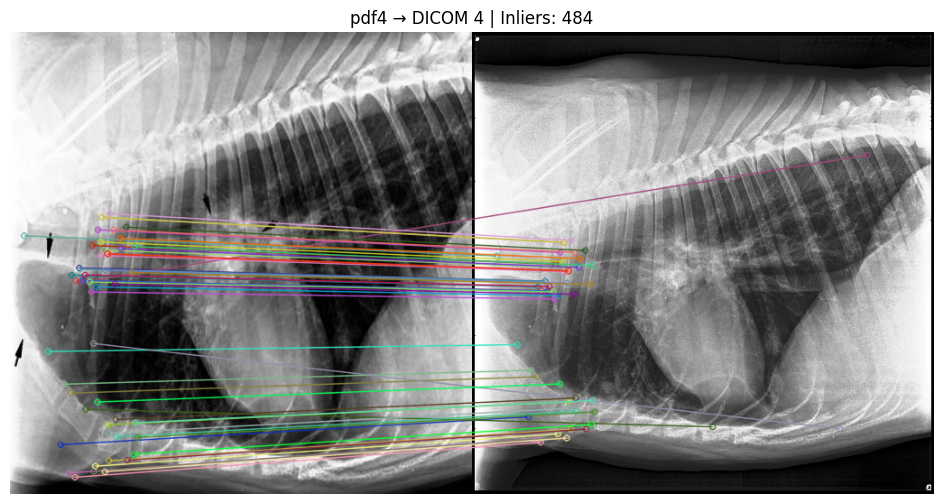

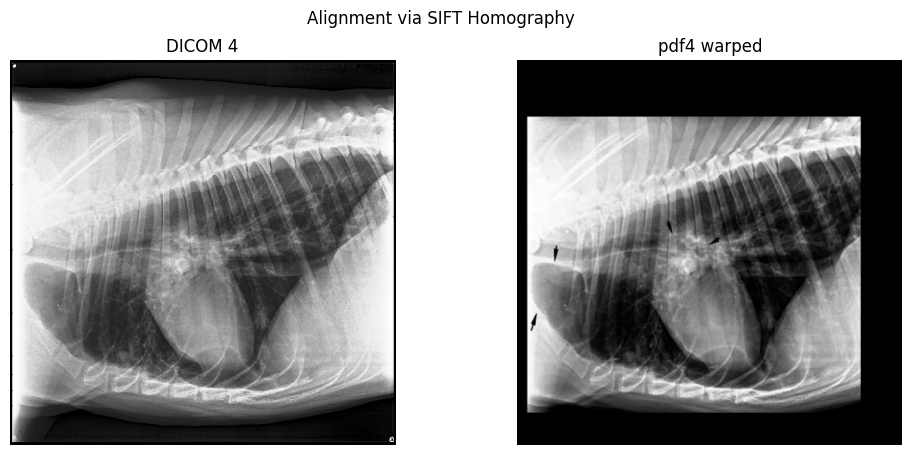

In [12]:
for pdf_key, data in sift_results.items():
    i = int(pdf_key.replace('pdf', '')) - 1
    j = data['dicom_idx']
    if data['H'] is None:
        print(f"No homography for {pdf_key}")
        continue

    pdf = pdf_images[i]
    dicom = dicom_images[j]

    # Draw matches
    match_img = cv2.drawMatches(
        pdf, data['kp_pdf'],
        dicom, data['kp_dicom'],
        data['good_matches'][:50], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(match_img)
    plt.title(f"{pdf_key} → DICOM {j+1} | Inliers: {data['inliers']}")
    plt.axis('off')
    plt.show()

    # Warp PDF onto DICOM
    warped = cv2.warpPerspective(pdf, data['H'], (dicom.shape[1], dicom.shape[0]))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(dicom, cmap='gray')
    plt.title(f"DICOM {j+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(warped, cmap='gray')
    plt.title(f"{pdf_key} warped")
    plt.axis('off')
    plt.suptitle(f"Alignment via SIFT Homography")
    plt.show()
